In [5]:
#!pip install control

In [6]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np
from control.timeresp import step_info

In [7]:
def plot_step_response(time, amplitud, setpoint=None, title='Respuesta al Escalon Unitario'):
  plt.figure(figsize=(10, 6))
  plt.plot(time, amplitud, linewidth=2, label='Respuesta del Sistema')
  if setpoint is not None:
      plt.axhline(y=setpoint, color='r', linestyle='--', alpha=0.8, label=f'Setpoint: {setpoint} °C')
  else:
      valor_final = amplitud[-1]
      plt.axhline(y=valor_final, color='r', linestyle='--', alpha=0.7, label=f'Valor Final: {valor_final:.2f}')

  plt.title(title)
  plt.xlabel("Tiempo (s)")
  plt.ylabel("Temperatura (°C)")
  plt.grid(True, which='both', linestyle='--', alpha=0.6)
  plt.legend(loc='best')
  plt.show()

In [8]:
def show_step_info(fdt, text = 'Informacion ante la Entrada de un Escalon Unitario'):
  info = step_info(fdt)
  print(text)
  print("\n")
  for key, value in info.items():
    print(f"{key}: {value}")

In [9]:
#Modelizacion Matematica de la Planta(Incubadora)

Altura = 0.29
Largo = 0.53
Ancho = 0.51

cant_huevos = 48

#Calculo de la Capacitancia Termica
Volumen = Altura * Largo * Ancho #m**3
Area = 2*(Largo*Ancho+Largo*Altura+Ancho*Altura)
print("Volumen: ",Volumen)
print("Area: ", Area)

den_aire = 1.225 #kg/m**3
masa_aire = den_aire * Volumen
cap_calorifica_aire = 1005 #J/kg°C

Cth_aire = cap_calorifica_aire*masa_aire
print("Capacitancia Termica del Aire:",Cth_aire)

masa_huevos = (60/1000) * cant_huevos

cap_cal_clara = 3800 #J/Kg°C
cap_cal_yema  = 3120
cap_cal_cascara = 888

Cth_huevos = ((50/100)*cap_cal_clara+(45/100)*cap_cal_yema+(5/100)*cap_cal_cascara)*masa_huevos
print("Capacitancia Termica de los Huevos: ", Cth_huevos)

masa_agua = 0.7 #Masa de agua = Volumen de Agua
cap_cal_agua = 4180
Cth_agua = masa_agua * cap_cal_agua
print("Capacitancia Termica del Agua: ",Cth_agua)

masa_del_equipo = 3.1 #kg
#Considerando la parte interna
mpp = (40/100)*masa_del_equipo
cap_cal_prolipropileno = 1900
Cth_plastico = mpp * cap_cal_prolipropileno
print("Capacitancia Termica del plastico",Cth_plastico)

Cth = Cth_agua + Cth_aire + Cth_huevos + Cth_plastico
print("Capacitancia Termica Total: ", Cth)

#Calculo de la Resistencia Termica
espesor_pared = 0.003 #m
h_interna = 5 #W/m**2°C Debido al ventilador interno
h_externa = 8 #W/m**2°C Conveccion Natural Aire Quieto
Kpp = 0.22 #W/m°C Conductividad Termica Del Material
R_coninterna = 1 / (h_interna*Area)
R_conduccion = espesor_pared / (Kpp*Area)
R_conexterna = 1 / (h_externa*Area)
Rth = R_coninterna + R_conduccion + R_conexterna
print("Resistencia Termica Total: ", Rth)

#Para la Funcion de Transferencia de la Planta G(s) = K/tao*s+1 o G(s) = K_norm/s+polo
K = Rth
tao = Rth * Cth

K_norm = K/tao
polo = 1/tao

Volumen:  0.078387
Area:  1.1438000000000001
Capacitancia Termica del Aire: 96.504195375
Capacitancia Termica de los Huevos:  9643.392
Capacitancia Termica del Agua:  2926.0
Capacitancia Termica del plastico 2356.0000000000005
Capacitancia Termica Total:  15021.896195375
Resistencia Termica Total:  0.2960625665644025


In [10]:
# Algebra de Bloques
actuador_rele_ssr = 1 #V->W
controlador = 1 #Mas adelante se usara un PI

num = [K]
den = [tao , 1]
system = ctrl.TransferFunction(num,den)
print("Funcion de Transferencia de la Planta: ",system,"\n")

num_norm = [K_norm]
den_norm = [1 , polo]
planta = ctrl.TransferFunction(num_norm, den_norm)
print("Funcion de Transferencia de la Planta 'zpk': ",planta,"\n")

Funcion de Transferencia de la Planta:  <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    0.2961
  ----------
  4447 s + 1 

Funcion de Transferencia de la Planta 'zpk':  <TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    6.657e-05
  -------------
  s + 0.0002248 



In [11]:
Fdtla_sin_compensador = controlador * actuador_rele_ssr * planta
print("\nFuncion de Transferencia a Lazo Abierto:\n ", Fdtla_sin_compensador,"\n")



Funcion de Transferencia a Lazo Abierto:
  <TransferFunction>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    6.657e-05
  -------------
  s + 0.0002248 



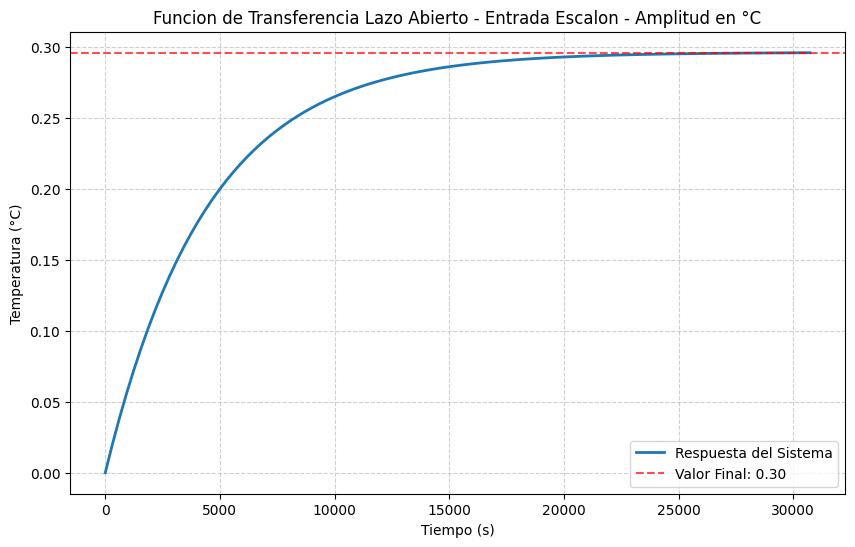



Informacion del Escalon - Entrada: 1°C: 


RiseTime: 9619.925283574228
SettlingTime: 17688.249714959064
SettlingMin: 0.2664563099079624
SettlingMax: 0.29606256656440255
Overshoot: 0.0
Undershoot: 0.0
Peak: 0.29576650399783844
PeakTime: 30721.69687334995
SteadyStateValue: 0.29606256656440255


In [12]:
#Respuesta a lazo abierto con escalon unitario
time_fdtla, response_fdtla  = ctrl.step_response(Fdtla_sin_compensador)
plot_step_response(time_fdtla, response_fdtla, title = 'Funcion de Transferencia Lazo Abierto - Entrada Escalon - Amplitud en °C')
print("\n")
show_step_info(Fdtla_sin_compensador, text='Informacion del Escalon - Entrada: 1°C: ')

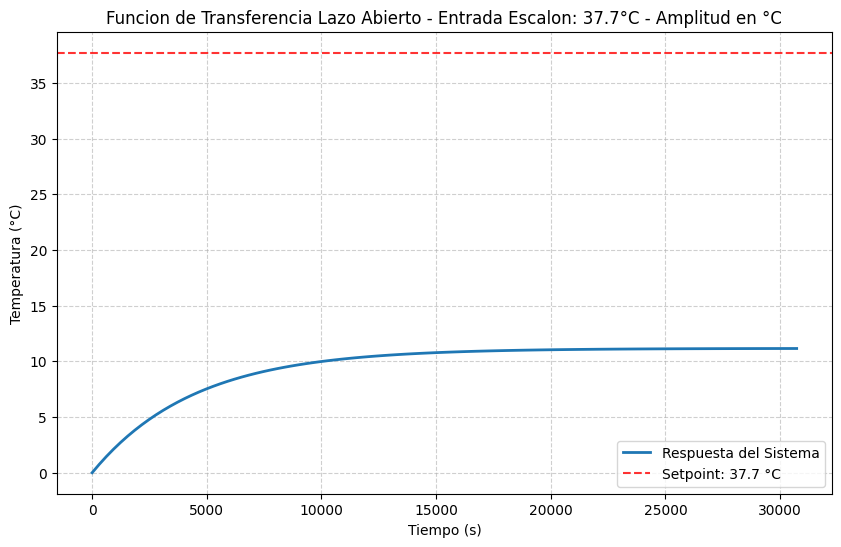



Informacion del Escalon - Entrada: 37.7°C: 


RiseTime: 9619.925283574228
SettlingTime: 17688.249714959064
SettlingMin: 10.045402883530183
SettlingMax: 11.161558759477977
Overshoot: 0.0
Undershoot: 0.0
Peak: 11.15039720071851
PeakTime: 30721.69687334995
SteadyStateValue: 11.161558759477977


In [13]:

desired_temperature = 37.7
time_fdtla, response_fdtla  = ctrl.step_response(desired_temperature*Fdtla_sin_compensador)
plot_step_response(time_fdtla, response_fdtla, setpoint = desired_temperature , title = 'Funcion de Transferencia Lazo Abierto - Entrada Escalon: 37.7°C - Amplitud en °C')
print("\n")
show_step_info(desired_temperature*Fdtla_sin_compensador, text='Informacion del Escalon - Entrada: 37.7°C: ')

### Información del Escalón

- **RiseTime (Tiempo de Subida)**:  El tiempo que tarda la respuesta en pasar del 10% al 90% de su valor final.

- **SettlingTime (Tiempo de Asentamiento)**:  El tiempo que tarda el sistema en estabilizarse dentro de un margen especificado (en este caso, 2% del valor final).

- **SettlingMin (Mínimo en el Asentamiento)**:  El valor mínimo alcanzado durante el tiempo de asentamiento, es decir, el punto más bajo alcanzado por la respuesta antes de estabilizarse.

- **SettlingMax (Máximo en el Asentamiento)**:  El valor máximo alcanzado durante el tiempo de asentamiento, es decir, el punto más alto alcanzado por la respuesta antes de estabilizarse.

- **Overshoot (Sobreimpulso)**:  El porcentaje de exceso de la respuesta respecto al valor final antes de estabilizarse. En este caso, no hay sobreimpulso, lo que indica que el sistema alcanzó su valor final sin excederlo.

- **Undershoot (Subimpulso)**:   El porcentaje en que la respuesta cae por debajo del valor final antes de estabilizarse. En este caso, no hubo subimpulso.

- **Peak (Pico Máximo)**:  El valor máximo alcanzado por la respuesta antes de estabilizarse. En este caso, el sistema alcanzó un valor máximo de 11.15°C durante la transición.

- **PeakTime (Tiempo al Pico)**:  El tiempo que tarda el sistema en alcanzar el valor máximo de la respuesta, es decir, el tiempo en que se alcanza el pico (en este caso, 11.15°C).

- **SteadyStateValue (Valor en Estado Estacionario)**:  El valor final al que el sistema se estabiliza después de un largo periodo de tiempo, una vez que todos los transitorios han desaparecido. Este es el valor que el sistema mantiene a medida que se estabiliza.


In [14]:
#Calculo del PI antes de cerrar el Lazo
#Pi form: PI(s) = Kp *(s+1/Ti)/s
polos = ctrl.poles(Fdtla_sin_compensador)
print("Los Polos de la Funcion de Transferencia a Lazo Abierto son: ", polos)

# Ordenamos por menor |parte real| (más cerca del eje imaginario)
polo_dominante = min(polos, key=lambda p: abs(p.real))

Ti = 1/np.abs(polo_dominante)
print("El Valor del Parametro 'Ti': ", Ti)

#Valor Kp:
zita = 1 #Criticamente Amortiguado
#defino un Tss de 10min -> 600segundos
T_ss = 600
#T_ss = 4/zita*frecuencia_natural
frecuencia_natural = 4/(zita*T_ss)
print("El valor de la Frecuencia Natural segun el Tss deseado es: ", frecuencia_natural)

#En el lugar de raices la frecuencia Natural tiene el mismo valor que el polo

s1 = -frecuencia_natural
Kp = 1 / np.abs(K_norm/s1)

print("El valor de la ganancia Kp es: ",Kp)

# Funcionde Transferencia del PI
num_PI = [1 , (1/Ti)]
den_PI = [1 , 0]
PI_s = Kp * ctrl.TransferFunction(num_PI,den_PI)
print("\nLa Funcion de Transferencia para Nuestro Compensador PI es: \n", PI_s)


Los Polos de la Funcion de Transferencia a Lazo Abierto son:  [-0.00022485+0.j]
El Valor del Parametro 'Ti':  4447.421142266756
El valor de la Frecuencia Natural segun el Tss deseado es:  0.006666666666666667
El valor de la ganancia Kp es:  100.14597463583334

La Funcion de Transferencia para Nuestro Compensador PI es: 
 <TransferFunction>: sys[18]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  100.1 s + 0.02252
  -----------------
          s



El sistema a Lazo Cerrado es:  <TransferFunction>: sys[23]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     0.006667 s + 1.499e-06
  ----------------------------
  s^2 + 0.006892 s + 1.499e-06 



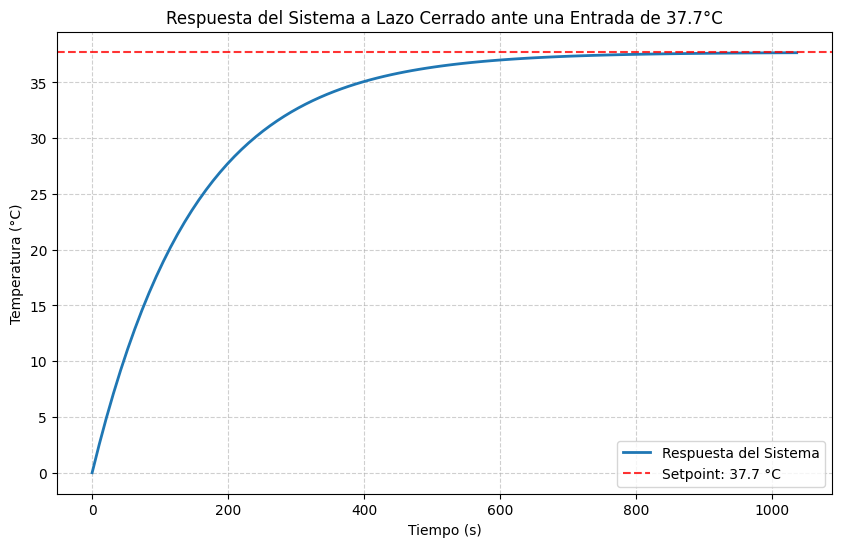


Informacion del Escalon del Sistema a Lazo Cerrado ante una Entrada de 37.7°C


RiseTime: 334.9214680718611
SettlingTime: 596.5788650030026
SettlingMin: 34.1840853822499
SettlingMax: 37.7
Overshoot: 0.0
Undershoot: 0.0
Peak: 37.66229999999954
PeakTime: 1036.1632918473204
SteadyStateValue: 37.7


In [15]:
# Analisis Funcion de Transferencia a Lazo Cerrado
G_s = PI_s * actuador_rele_ssr * planta
H_s = 1
sistema_a_lazo_cerrado = ctrl.feedback(G_s,H_s)
print("\nEl sistema a Lazo Cerrado es: ", sistema_a_lazo_cerrado,"\n")

time_c , response_c = ctrl.step_response(desired_temperature*sistema_a_lazo_cerrado)
plot_step_response(time_c, response_c, setpoint = desired_temperature, title = 'Respuesta del Sistema a Lazo Cerrado ante una Entrada de 37.7°C')
show_step_info(desired_temperature*sistema_a_lazo_cerrado, text = '\nInformacion del Escalon del Sistema a Lazo Cerrado ante una Entrada de 37.7°C')

In [16]:
#Codigo para Calcular el Error en Estado Estacionario:

s = ctrl.TransferFunction.s

G = Fdtla_sin_compensador * PI_s

print("Función de Transferencia a Lazo Abierto PI(s)*G(s):")
print(G)

Kp = ctrl.dcgain(G)

G_aux_kv = ctrl.minreal(s * G, verbose=False)
Kv = ctrl.dcgain(G_aux_kv)

G_aux_ka = ctrl.minreal(s**2 * G, verbose=False)
Ka = ctrl.dcgain(G_aux_ka)

print(f"\nKp = {np.real(Kp)}")
print(f"Kv = {np.real(Kv)}")
print(f"Ka = {np.real(Ka)}")

if np.isinf(Kp):
    ess_e = 0.0
else:
    ess_e = 1 / (1 + Kp)

if Kv == 0:
    ess_r = float('inf')
elif np.isinf(Kv):
    ess_r = 0.0
else:
    ess_r = 1 / Kv

if Ka == 0:
    ess_p = float('inf')
elif np.isinf(Ka):
    ess_p = 0.0
else:
    ess_p = 1 / Ka

print("-" * 40)
print(f"Error estacionario ante Escalón (ess_e)  = {ess_e}")
print(f"Error estacionario ante Rampa (ess_r)    = {ess_r}")
print(f"Error estacionario ante Parábola (ess_p) = {ess_p}")


Función de Transferencia a Lazo Abierto PI(s)*G(s):
<TransferFunction>: sys[32]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.006667 s + 1.499e-06
  ----------------------
    s^2 + 0.0002248 s

Kp = inf
Kv = 0.006666666666666667
Ka = 0.0
----------------------------------------
Error estacionario ante Escalón (ess_e)  = 0.0
Error estacionario ante Rampa (ess_r)    = 150.0
Error estacionario ante Parábola (ess_p) = inf


#Prueba/Correccion en informe.

In [17]:
#Codigo para Calcular el Error en Estado Estacionario:

s = ctrl.TransferFunction.s

G = Fdtla_sin_compensador

print("Función de Transferencia a Lazo Abierto PI(s)*G(s):")
print(G)

Kp = ctrl.dcgain(G)

G_aux_kv = ctrl.minreal(s * G, verbose=False)
Kv = ctrl.dcgain(G_aux_kv)

G_aux_ka = ctrl.minreal(s**2 * G, verbose=False)
Ka = ctrl.dcgain(G_aux_ka)

print(f"\nKp = {np.real(Kp)}")
print(f"Kv = {np.real(Kv)}")
print(f"Ka = {np.real(Ka)}")

if np.isinf(Kp):
    ess_e = 0.0
else:
    ess_e = 1 / (1 + Kp)

if Kv == 0:
    ess_r = float('inf')
elif np.isinf(Kv):
    ess_r = 0.0
else:
    ess_r = 1 / Kv

if Ka == 0:
    ess_p = float('inf')
elif np.isinf(Ka):
    ess_p = 0.0
else:
    ess_p = 1 / Ka

print("-" * 40)
print(f"Error estacionario ante Escalón (ess_e)  = {ess_e}")
print(f"Error estacionario ante Rampa (ess_r)    = {ess_r}")
print(f"Error estacionario ante Parábola (ess_p) = {ess_p}")

Función de Transferencia a Lazo Abierto PI(s)*G(s):
<TransferFunction>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    6.657e-05
  -------------
  s + 0.0002248

Kp = 0.29606256656440255
Kv = 0.0
Ka = 0.0
----------------------------------------
Error estacionario ante Escalón (ess_e)  = 0.7715676895528246
Error estacionario ante Rampa (ess_r)    = inf
Error estacionario ante Parábola (ess_p) = inf



El sistema a lazo cerrado sin compensador es: 
 <TransferFunction>: sys[48]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    6.657e-05
  -------------
  s + 0.0002914


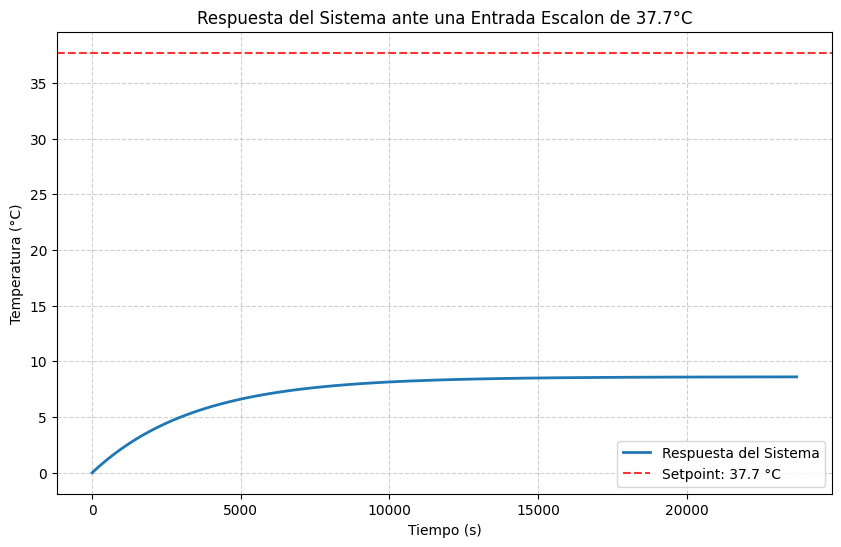

Informacion Ante Entrada Escalon 37.7°C a Lazo Cerrado


RiseTime: 7422.423524718165
SettlingTime: 13647.68196480437
SettlingMin: 7.750708293472668
SettlingMax: 8.611898103858513
Overshoot: 0.0
Undershoot: 0.0
Peak: 8.603286205754662
PeakTime: 23703.868675712853
SteadyStateValue: 8.611898103858513


In [18]:
fdtla_sinc = Fdtla_sin_compensador
realimentacion = H_s
closed_loop = ctrl.feedback(fdtla_sinc,realimentacion)
print("\nEl sistema a lazo cerrado sin compensador es: \n", closed_loop)
time_sinc, response_sinc = ctrl.step_response(desired_temperature*closed_loop)
plot_step_response(time_sinc, response_sinc, setpoint=desired_temperature ,title ='Respuesta del Sistema ante una Entrada Escalon de 37.7°C')
show_step_info(desired_temperature*closed_loop, text="Informacion Ante Entrada Escalon 37.7°C a Lazo Cerrado")